# Бэггинг и случайный лес

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score, validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

import numpy as np
import seaborn as sns

Загрузка датасета digits с помощью функции load_digits из sklearn.datasets и подготовка матрицы признаков X и ответов на обучающей выборке y (потребуются поля data и target в объекте, который возвращает load_digits).

In [3]:
digits = load_digits()
print(digits.data.shape)
print(digits.DESCR)

(1797, 64)
Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each e

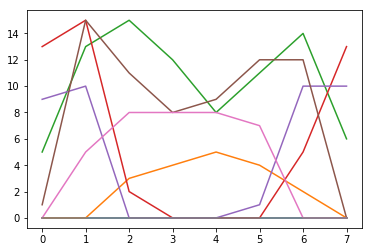

In [4]:
plt.gray()
plt.plot(digits.images[0])
plt.show()

In [5]:
X = digits.data
y = digits.target

Для оценки качества далее нужно использовать cross_val_score из sklearn.cross_validation с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Предлагается использовать k=10, чтобы полученные оценки качества имели небольшой разброс, и было проще проверить полученные ответы. На практике же часто хватает и k=5. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) вызовите метод .mean() у массива, который возвращает cross_val_score.

С небольшой вероятностью можно натолкнуться на случай, когда полученное качество в каком-то из пунктов не попадет в диапазон, заданный для правильных ответов - в этом случае необходимо попробовать перезапустить ячейку с cross_val_score несколько раз и выбрать наиболее «типичное» значение.

Если захочется ускорить вычисление cross_val_score - можно попробовать использовать параметр n_jobs, но нужно быть осторожным: в одной из старых версий sklearn была ошибка, которая приводила к неверному результату работы cross_val_score при задании n_jobs отличным от 1. Сейчас такой проблемы возникнуть не должно, но проверить, что все в порядке, не будет лишним.

1.

Создадим DecisionTreeClassifier с настройками по умолчанию и измерим качество его работы с помощью cross_val_score. Эта величина и будет ответом в пункте 1.

In [6]:
dt_classifier = DecisionTreeClassifier()

In [7]:
cvs = cross_val_score(dt_classifier, X, y, cv=10)

In [8]:
print(cvs)
print('Mean model quality value: ' + str(cvs.mean()))

[0.81621622 0.8579235  0.82872928 0.81666667 0.79888268 0.8603352
 0.89385475 0.83707865 0.81355932 0.79545455]
Mean model quality value: 0.8318700806790759


In [9]:
with open("answer1.txt", "w") as fout:
    fout.write(str(cvs.mean()))

2.

Воспользуемся BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используем в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100.

Качество классификации новой модели - ответ в пункте 2. Обратите внимание, как соотносится качество работы композиции решающих деревьев с качеством работы одного решающего дерева.

In [10]:
bagging = BaggingClassifier(dt_classifier, n_estimators=100)

In [11]:
cvs = cross_val_score(bagging, X, y, cv=10)

In [12]:
print(cvs)
print('Mean model quality value: ' + str(cvs.mean()))

[0.88108108 0.95081967 0.89502762 0.93333333 0.91061453 0.98882682
 0.94972067 0.90449438 0.86440678 0.93181818]
Mean model quality value: 0.921014306552981


In [13]:
with open("answer2.txt", "w") as fout:
    fout.write(str(cvs.mean()))

3.

Теперь изучим параметры BaggingClassifier и выберем их такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на sqrt(d) случайных признаков. Качество работы получившегося классификатора - ответ в пункте 3. Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков.

In [14]:
n_features = digits.data.shape[1]
bagging = BaggingClassifier(dt_classifier, n_estimators=100, max_features=int(np.sqrt(n_features)))

In [15]:
cvs = cross_val_score(bagging, X, y, cv=10)

In [16]:
print(cvs)
print('Mean model quality value: ' + str(cvs.mean()))

[0.8972973  0.94535519 0.92265193 0.88888889 0.93296089 0.93296089
 0.96089385 0.97191011 0.88700565 0.92613636]
Mean model quality value: 0.9266061079316202


In [17]:
with open("answer3.txt", "w") as fout:
    fout.write(str(cvs.mean()))

4.

Наконец, попробуем выбрать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier. Будем выбирать опять же sqrt(d) признаков. Качество полученного классификатора на контрольной выборке и будет ответом в пункте 4.

In [18]:
dt_classifier = DecisionTreeClassifier(max_features=int(np.sqrt(n_features)))
bagging = BaggingClassifier(dt_classifier, n_estimators=100)

In [19]:
cvs = cross_val_score(bagging, X, y, cv=10)

In [20]:
print(cvs)
print('Mean model quality value: ' + str(cvs.mean()))

[0.91351351 0.96721311 0.93922652 0.94444444 0.95530726 0.97206704
 0.97765363 0.97191011 0.93220339 0.94318182]
Mean model quality value: 0.9516720845381844


In [21]:
with open("answer4.txt", "w") as fout:
    fout.write(str(cvs.mean()))

5.

Полученный в пункте 4 классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest, поэтому почему бы не сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble. Затем изучите, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева. Для наглядности лучше построить графики зависимости качества от значений параметров, но для сдачи задания это делать не обязательно.

In [22]:
rf_classifier = RandomForestClassifier()
bagging = BaggingClassifier(rf_classifier, n_estimators=100)

In [23]:
cvs = cross_val_score(bagging, X, y, cv=10)

In [24]:
print(cvs)
print('Mean model quality value: ' + str(cvs.mean()))

[0.91351351 0.96721311 0.9281768  0.95555556 0.95530726 0.97765363
 0.97206704 0.95505618 0.92090395 0.94318182]
Mean model quality value: 0.9488628865123531


In [25]:
with open("answer5.txt", "w") as fout:
    answer = str(2) + ' ' + str(3) + ' ' + str(4) + ' ' + str(7)
    fout.write(answer)

In [ ]:
param_range = np.array([10, 50, 100, 150])
train_scores, test_scores = validation_curve(bagging, X, y, param_name="n_estimators", param_range=param_range, cv=10, scoring="accuracy")

In [32]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
print(train_scores_mean, test_scores_mean)

(array([ 0.9996909,  1.       ,  1.       ,  1.       ]), array([ 0.94768927,  0.95387176,  0.94938689,  0.94941504]))


In [33]:
param_range = np.array([5, 10, 20, 40])
train_scores, test_scores = validation_curve(bagging, X, y, param_name="max_features", param_range=param_range, cv=10, scoring="accuracy")

In [34]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
print(train_scores_mean, test_scores_mean)

(array([ 1.,  1.,  1.,  1.]), array([ 0.91158914,  0.93827933,  0.95271891,  0.95107631]))


In [38]:
param_range = np.array([5, 10, 50, 100])
train_scores, test_scores = validation_curve(bagging, X, y, param_name="base_estimator__max_depth", param_range=param_range, cv=10, scoring="accuracy")

In [39]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
print(train_scores_mean, test_scores_mean)

(array([ 0.97075316,  1.        ,  1.        ,  1.        ]), array([ 0.91874664,  0.95333507,  0.95163436,  0.95271258]))
